**Problem 1:** *Capacitated facility location.* 

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the attached script to generate the data, and to visualize the results. You are supposed to play with different configurations and sizes of the problem. Please make your report detailed (otherwise lower amount of points then indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.

In [101]:
from gurobipy import *

In [259]:
# initialization

import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

C = 40; # number of clients
clients = np.random.rand(2,C); #client positions
F = 20; #number of facilities
facilities = np.random.rand(2,F);

#capacities = np.ones((F,))*4; #maximum number of clients per facility
capacities = np.array([2, 3, 4, 2, 5, 3, 2, 1, 2, 3, 4, 3, 2, 1, 2, 2, 2, 3, 2, 3]);

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose();
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose();

assignment_costs = 3*(dx*dx + dy*dy); #the assignment cost is the distance squared

#opening_costs = np.ones((F,));
opening_costs = np.array([1, 2, 1, 2, 1, 1.2, 1.3, 2, 1, 1, 1.4, 2, 1, 1, 1, 1, 1.5, 1.3, 2, 1]);

# plot the solution
def plot_solution(facilities_opened, clients_assignment):
    plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
    plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
    plt.show()

For each person we will find the closest facility.
We will try to open the closest non-opened facility with >0 capacity if 
it will be more efficient than just attach the person to closest opened non-full facility.
Complexity is: $O\left(C\times F\right)$

Greedy cost:  35.6495154779


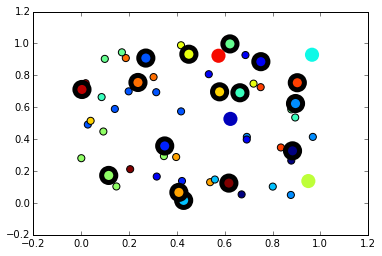

In [260]:
# greedy solution

total_cost = 0

places_left = np.copy(capacities)
taken = np.zeros(F)
clients_assignment = []

for i in xrange(C):
    no_min_cost = op_min_cost = dist = 1e10
    no_cnd = op_cnd = -1
    no_cnd_f = op_cnd_f = False
    
    # not opened candidate
    for j in xrange(F):
        dist = assignment_costs[j, i]
        
        if (taken[j] == 0) and (capacities[j] > 0) and ((dist + opening_costs[j]) < no_min_cost):
            no_min_cost = dist + opening_costs[j]
            no_cnd = j
            no_cnd_f = True
    
    #already opend candidate
    for j in xrange(F):
        dist = assignment_costs[j, i]
        
        if (taken[j] == 1 and places_left[j] > 0) and (dist < op_min_cost):
            op_min_cost = dist
            op_cnd = j
            op_cnd_f = True
    
    assert(op_cnd_f or no_cnd_f)
    
    if op_cnd_f and op_min_cost < no_min_cost:
        places_left[op_cnd] -= 1
        total_cost += op_min_cost
        clients_assignment.append(op_cnd)
    else:
        places_left[no_cnd] -= 1
        taken[no_cnd] = 1
        total_cost += no_min_cost
        clients_assignment.append(no_cnd)
        
print 'Greedy cost: ', total_cost
        
plot_solution(taken, clients_assignment)

* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.

Our local optimization will start at the state $X$ where every client is randomly assigned to a facility. The neighborhood of $X$ will be all such states which could be obtained with a single person transition or 2 persons swap. Thus, there will be $C \times F + C \times C$ points in the neighborhood.

Move:  68.3953653661
Swap:  63.5341831888
Swap:  58.9384833946
Swap:  54.7518092908
Swap:  51.0651528237
Swap:  48.6349116038
Swap:  46.3240451634
Swap:  44.0166957908
Swap:  42.044674182
Swap:  40.218179769
Swap:  38.4161332471
Move:  37.0523202735
Swap:  35.8090587169
Swap:  34.5668458377
Move:  33.5788576518
Move:  32.666752586
Swap:  31.8187001804
Swap:  31.0435073236
Swap:  30.2886839155
Swap:  29.6379736733
Move:  29.0023196396
Swap:  28.5186823036
Swap:  28.0394358865
Move:  27.622292549
Swap:  27.2447704276
Swap:  26.8975611098
Swap:  26.6051671464
Swap:  26.3249897427
Swap:  26.0724849892
Move:  25.8590012818
Swap:  25.683747584
Swap:  25.5556449069
Swap:  25.4318808265
Swap:  25.3341581522
Move:  25.2532666904
Move:  23.8903699143
Swap:  23.8118964303
Swap:  23.7563373208
Swap:  23.689595638


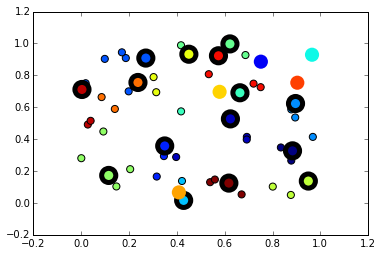

In [261]:
np.random.seed(1)

# initial state generation
def get_init_x():
    places_left = np.copy(capacities)
    x = {}
    i = 0

    while i < C:
        to = np.random.randint(0, F)

        if (places_left[to] == 0):
            continue

        places_left[to] -= 1

        x[i] = to
        i += 1
        
    return (x, places_left)

def unique(seq):
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if not (x in seen or seen_add(x))]

# state cost function
def cost(x):
    res = 0.
    
    for f in unique(x.values()):
        res += opening_costs[f]

    for i in xrange(C):
        res += assignment_costs[x[i], i] 
    
    return res
        
def get_best_in_neighborhood(x, places_left):
    best_cost = cost(x)
    orig_x = x.copy()
    x_next = {}
    
    # first try to swap 2 persons
    for i in xrange(C):
        for j in xrange(i + 1, C):
            t = x[i]
            x[i] = x[j]
            x[j] = t
            cx = cost(x)

            if (cx < best_cost):
                best_cost = cx
                x_next = x.copy()
            
            t = x[i]
            x[i] = x[j]
            x[j] = t
    
    # now just one person relocation
    from_fc = to_fc = -1
    
    for i in xrange(C):
        for j in xrange(F):
            if places_left[j] > 0:
                x[i] = j
                cx = cost(x)
                
                if (cx < best_cost):
                    best_cost = cx
                    x_next = x.copy()
                    from_fc = orig_x[i]
                    to_fc = j
                
                x[i] = orig_x[i]
    
    return (x_next, from_fc, to_fc)

# util functions
def plot_x(x):
    taken = np.zeros(F)
    
    for f in unique(x.values()):
        taken[f] = 1

    plot_solution(taken, x.values())

x, places_left = get_init_x()
last_x = x

while True:    
    x, f, t = get_best_in_neighborhood(x, places_left)
    
    if not bool(x):
        break
    
    last_x = x
    
    if (f >= 0):
        print "Move: ", cost(x)
        places_left[f] += 1
        places_left[t] -= 1
    else:
        print "Swap: ", cost(x)

plot_x(last_x)

* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

22.8916016842


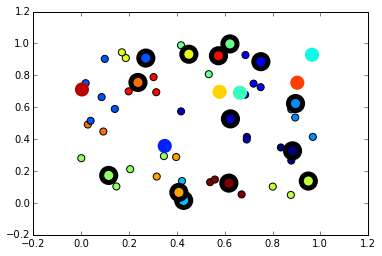

In [262]:
# simulated annealing algorithm implementation

np.random.seed(1)

def get_neighborhood(x, places_left):
    orig_x = x.copy()
    
    # list of tripples (state, transfered from, transfered to)
    # we need transfered info to update our capacities data
    res = [] 

    # first add all swaps
    for i in xrange(C):
        for j in xrange(i + 1, C):
            t = x[i]
            x[i] = x[j]
            x[j] = t

            res.append((x.copy(), -1, -1))
            
            t = x[i]
            x[i] = x[j]
            x[j] = t
    
    # now add all single person transitions
    for i in xrange(C):
        for j in xrange(F):
            if places_left[j] > 0 and not (x[i] == j):
                x[i] = j
                res.append((x.copy(), orig_x[i], j))
                x[i] = orig_x[i]
    
    return res

x, places_left = get_init_x()
bestx = x; bestf = 1e10; T = 10000.; mp = 0.999
MAX_ITER = 40000
niter = 0

while niter < MAX_ITER:
    nh = get_neighborhood(x, places_left)
    y = nh[np.random.randint(0, len(nh))]

    dE = cost(y[0]) - cost(x)
    
    if np.exp(-dE / T) > np.random.rand():
        if y[1] >= 0:
            places_left[y[1]] += 1
            places_left[y[2]] -= 1
    
        x = y[0]
        
        if cost(x) < bestf:
            bestx = x
            bestf = cost(x)
    
    T *= mp
    niter += 1

print bestf
plot_x(bestx)

With much time and iterations simulated annealing gives just a slightly better result. For some configurations it was quite close to the optimal solution.

Below is the solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code. 

Optimize a model with 80 rows, 820 columns and 1660 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 5e+00]
  Objective range [2e-04, 4e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 74.1567
Presolve removed 2 rows and 0 columns
Presolve time: 0.01s
Presolved: 78 rows, 820 columns, 1656 nonzeros
Variable types: 0 continuous, 820 integer (820 binary)

Root relaxation: objective 2.164004e+01, 141 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.64004    0    2   74.15669   21.64004  70.8%     -    0s
H    0     0                      22.4331613   21.64004  3.54%     -    0s
H    0     0                      21.9133475   21.64004  1.25%     -    0s
     0     0   21.70292    0    9   21.91335   21.70292  0.96%     -    0s
     0     0   21.70292    0    2   21.91335   21.70292

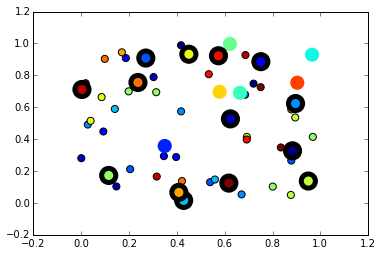

In [263]:
# create the model
m = Model("facility")

y = []
for i_f in range(F):
    y.append(m.addVar(vtype=GRB.BINARY))

x = []    
for i_f in range(F):
    x.append([])
    for i_c in range(C):
        x[i_f].append(m.addVar(vtype=GRB.BINARY))

# the objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# update model to integrate new variables
m.update()

# set optimization objective - minimize sum of fixed costs
obj_summands = []
for i_f in range(F):
    obj_summands.append(opening_costs[i_f]*y[i_f])
    
for i_f in range(F):
    for i_c in range(C):
        obj_summands.append(assignment_costs[i_f][i_c]*x[i_f][i_c])

m.setObjective(quicksum(obj_summands))  

# set constraints
for i_c in range(C):
    client_constr_summands = [x[i_f][i_c] for i_f in range(F)]
    m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)
        
for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(sum(facility_constr_summands), GRB.LESS_EQUAL, capacities[i_f]*y[i_f])       

for i_f in range(F):        
    facility_constr_summands = [x[i_f][i_c] for i_c in range(C)]
    m.addConstr(max(facility_constr_summands), GRB.LESS_EQUAL, y[i_f])     

# optimize
  
m.optimize()

# plot the solution
facilities_opened = [y[i_f].X for i_f in range(F)]    
clients_assignment = [i_f for i_f in range(F) for i_c in range(C) if x[i_f][i_c].X != 0]

plt.scatter(clients[0,:], clients[1,:], s=50.0, c=clients_assignment)
plt.scatter(facilities[0,:], facilities[1,:], s=200.0, c=range(F), linewidth = [5*el for el in facilities_opened])
plt.show()


** Problem 2 **: *Optimal vehicle speed scheduling (6 points) *-- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough. **NB**: later in the course we will get back to this problem and attack it with a different method.


In [256]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

%matplotlib inline

mat_contents = sio.loadmat('veh_sched_data.mat')

a = np.float64(mat_contents['a'])
b = np.float64(mat_contents['b'])
c = np.float64(mat_contents['c'])
d = np.array(mat_contents['d'], dtype=np.float64)
n = np.int(mat_contents['n'])
smin = np.array(mat_contents['smin'], dtype=np.float64)
smax = np.array(mat_contents['smax'], dtype=np.float64)
tau_min = np.array(mat_contents['tau_min'], dtype=np.float64)
tau_max = np.array(mat_contents['tau_max'], dtype=np.float64)

DISCR_RATE = 100
inf = 1e10

# exact time we reach i'th waypoint
# with spending minimal amount of fuel.
# i'th slice will give us a linsapce(tau_min_i, tau_max_i, DISCR_RATE)
time = np.ones((n + 1, DISCR_RATE), dtype=np.float64) * inf

# minimum amount of fuel for each step and time
fuel = np.ones((n + 1, DISCR_RATE), dtype=np.float64) * inf

for i in xrange(DISCR_RATE):
    fuel[0, i] = 0
    time[0, i] = 0

# pointers to retrieve our solution
paths = np.zeros((n + 1, DISCR_RATE), dtype=int)

for i in xrange(n):
    for j in xrange(DISCR_RATE):
        speed_rng = np.linspace(d[i] / (tau_max[i] - time[i, j]), 
                                d[i] / (tau_min[i] - time[i, j]), 
                                num = DISCR_RATE)

        for s in speed_rng:
            if (s <= smax[i]) and (s >= smin[i]):
                time_di = np.float64(d[i] / s)
                cnd = (a * np.power(s, 2) + b * s + c) * time_di + fuel[i, j]
                time_total = time[i, j] + time_di
                delta = (tau_max[i] - tau_min[i]) / DISCR_RATE
                idx = np.int(np.floor((time_total - tau_min[i]) / delta))
                if (idx >= 100):
                    print idx
                    continue
                if (cnd < fuel[i + 1, idx]):
                    fuel[i + 1, idx] = cnd
                    paths[i + 1, idx] = j
                    time[i + 1, idx] = time_total

# Assuming that dataframes df1 and df2 are already defined:
# print "Dataframe 2:"
# 

pd.set_option('display.max_columns', None)
df = pd.DataFrame(time)
display(df)

# res_idx = 0
# min_fuel = 1e10

# x = []
# y = []

# for i in xrange(DISCR_RATE):
#     if (fuel[n, i] < min_fuel):
#         min_fuel = fuel[n, i]
#         res_idx = i


# print i, min_fuel, fuel[n, :]

#for i in xrange(n, )

100
100
100
100
103
100
103
100
103
106
100
103
106
100
102
106
109
100
102
105
108
100
102
105
108
111
100
102
104
107
110
100
102
104
107
110
112
100
102
104
106
109
112
115
100
101
104
106
108
111
114
100
101
103
105
108
110
113
115
100
101
103
105
107
110
112
115
118
100
101
103
105
107
109
111
114
116
119
100
101
103
105
106
108
111
113
115
118
120
100
101
103
104
106
108
110
112
114
117
119
122
100
101
102
104
106
108
109
112
114
116
118
121
124
100
101
102
104
105
107
109
111
113
115
117
120
122
125
100
101
102
104
105
107
108
110
112
114
116
118
121
123
126
100
101
102
103
105
106
108
110
111
113
115
117
120
122
124
127
100
101
102
103
105
106
108
109
111
113
114
116
118
121
123
126
128
100
101
102
103
104
106
107
109
110
112
113
115
117
119
121
124
126
129
100
101
102
103
104
105
107
108
110
111
113
115
116
118
120
122
125
127
130
100
101
102
103
104
105
106
108
109
111
112
114
115
117
119
121
123
126
128
130
100
100
101
103
104
105
106
107
109
110
111
113
115
116
118
120
122


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
1,1.080900e+00,1.124499e+00,1.152389e+00,1.191801e+00,1.234004e+00,1.267671e+00,1.303227e+00,1.340835e+00,1.367137e+00,1.408583e+00,1.452620e+00,1.483540e+00,1.515806e+00,1.549506e+00,1.584738e+00,1.621610e+00,1.660239e+00,1.700753e+00,1.743294e+00,1.765373e+00,1.811251e+00,1.835096e+00,1.884721e+00,1.910554e+00,1.964404e+00,1.992484e+00,2.021377e+00,2.051122e+00,2.081754e+00,2.145849e+00,2.179400e+00,2.214016e+00,2.249750e+00,2.286656e+00,2.324793e+00,2.364224e+00,1.000000e+10,2.405016e+00,2.447240e+00,2.490973e+00,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,10000000000,10000000000,10000000000,10000000000
2,2.726500e+00,2.766844e+00,2.802984e+00,2.840934e+00,2.879034e+00,2.920391e+00,2.955545e+00,2.991847e+00,3.031638e+00,3.069089e+00,3.105577e+00,3.143865e+00,3.182246e+00,3.224557e+00,3.260605e+00,3.298775e+00,3.334782e+00,3.371872e+00,3.410337e+00,3.452110e+00,3.486822e+00,3.522334e+00,3.563125e+00,3.599823e+00,3.637886e+00,3.676191e+00,3.712812e+00,3.754397e+00,3.791808e+00,3.829783e+00,3.868268e+00,3.907170e+00,3.938861e+00,3.978504e+00,4.018349e+00,4.054281e+00,4.097428e+00,4.163312e+00,4.173646e+00,4.240639e+00,4.268604e+00,4.281370e+00,1.000000e+10,4.373641e+00,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.000000e+10,1.000000e+10,10000000000,1.000000e+10,1.0000

In [201]:
for i in xrange(0, 10, -1):
    print i